**Importiere die notwendigen Packages**

In [1]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import folium 



Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [2]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

Importiere einen Datensatz von der **DWH_INT** Dropzone.

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**: https://data.integ.stadt-zuerich.ch/dataset/bfs_ste_bev_hauptsprachen_seit1860_od3032

In [7]:
# Filepath
fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/INT_DWH/bfs_ste_bev_hauptsprachen_seit1860_od3032/BEV303OD3032.csv"

# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
   #usecols=[0,1,2,3,4,6],
   #names=['stationid','year','month','avgtemp','latitude','longitude','elevation','station','countryid','country'],
   #skiprows=1,
   # parse_dates=[0],
    parse_dates=True,
    #date_parser=lambda x: pd.to_datetime(x, format="%Y"), 
    #index_col="date_time",
    low_memory=False    
    )

In der Folge ein paar erste Tests:

In [8]:
type(data2betested)

pandas.core.frame.DataFrame

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [9]:
data2betested.head(3)

,Jahr,Sprache,AnzBev,AntBev,untAnzBevKI,obAnzBevKI,untAntBevKI,obAntBevKI
0,2019,Deutsch,306420,76,303780,309060,75,76
1,2019,Englisch,46000,11,43990,48010,11,12
2,2019,Italienisch,25180,6,23710,26640,6,7


In [10]:
data2betested.dtypes

Jahr             int64
Sprache         object
AnzBev         float64
AntBev         float64
untAnzBevKI    float64
obAnzBevKI     float64
untAntBevKI    float64
obAntBevKI     float64
dtype: object

In [11]:
data2betested.shape

(183, 8)

Beschreibe einzelne Attribute

In [12]:
data2betested.describe()

,Jahr,AnzBev,AntBev,untAnzBevKI,obAnzBevKI,untAntBevKI,obAntBevKI
count,183,182,182,100,100,100,100
mean,1979,47377,15,45954,48379,12,13
std,50,90297,28,84015,84813,22,22
min,1860,31,0,730,1310,0,0
25%,1950,4713,2,10782,12628,3,3
50%,2010,12995,4,14885,17240,4,4
75%,2015,30759,8,31995,35538,9,9
max,2019,384950,100,303780,309060,80,81


Wie viele Nullwerte gibt es im Datensatz?

In [13]:
data2betested.isnull().sum()

Jahr            0
Sprache         0
AnzBev          1
AntBev          1
untAnzBevKI    83
obAnzBevKI     83
untAntBevKI    83
obAntBevKI     83
dtype: int64

Wandle die Spalte Jahr von Int zu **Datetime** um. Dies wird in den meisten Grafiken so benötigt.

In [14]:
data2betested['Jahr']=pd.to_datetime(data2betested['Jahr'], format='%Y')

#TO DO --> setze das Datum auf den 31.12. der Jahres.
#test=data2betested[['StichtagDatJahr']].date().replace(month=12, day=31)

data2betested

,Jahr,Sprache,AnzBev,AntBev,untAnzBevKI,obAnzBevKI,untAntBevKI,obAntBevKI
0,2019-01-01,Deutsch,306420,76,303780,309060,75,76
1,2019-01-01,Englisch,46000,11,43990,48010,11,12
2,2019-01-01,Italienisch,25180,6,23710,26640,6,7
3,2019-01-01,Französisch,18970,5,17650,20300,4,5
4,2019-01-01,Serbisch_Kroatisch,13060,3,12040,14080,3,4
...,...,...,...,...,...,...,...,...
178,1860-01-01,Deutsch,51396,100,nan,nan,nan,nan
179,1860-01-01,Italienisch,31,0,nan,nan,nan,nan
180,1860-01-01,Französisch,147,0,nan,nan,nan,nan
181,1860-01-01,Rätoromanisch,nan,nan,nan,nan,nan,nan


Bereite die Daten für die Grafik unten vor

In [15]:
Jahre = data2betested.groupby("Jahr")
len(Jahre)

25

In [16]:
for key, group in Jahre:
    print(key, len(group))

1860-01-01 00:00:00 5
1870-01-01 00:00:00 5
1880-01-01 00:00:00 5
1888-01-01 00:00:00 5
1900-01-01 00:00:00 5
1910-01-01 00:00:00 5
1920-01-01 00:00:00 5
1930-01-01 00:00:00 5
1941-01-01 00:00:00 5
1950-01-01 00:00:00 5
1960-01-01 00:00:00 5
1970-01-01 00:00:00 7
1980-01-01 00:00:00 7
1990-01-01 00:00:00 7
2000-01-01 00:00:00 7
2010-01-01 00:00:00 10
2011-01-01 00:00:00 10
2012-01-01 00:00:00 10
2013-01-01 00:00:00 10
2014-01-01 00:00:00 10
2015-01-01 00:00:00 10
2016-01-01 00:00:00 10
2017-01-01 00:00:00 10
2018-01-01 00:00:00 10
2019-01-01 00:00:00 10


In [17]:
myJahr = "2019-01-01"
aktuellesJahr=Jahre.get_group(myJahr)   
aktuellesJahr

,Jahr,Sprache,AnzBev,AntBev,untAnzBevKI,obAnzBevKI,untAntBevKI,obAntBevKI
0,2019-01-01,Deutsch,306420,76,303780,309060,75,76
1,2019-01-01,Englisch,46000,11,43990,48010,11,12
2,2019-01-01,Italienisch,25180,6,23710,26640,6,7
3,2019-01-01,Französisch,18970,5,17650,20300,4,5
4,2019-01-01,Serbisch_Kroatisch,13060,3,12040,14080,3,4
5,2019-01-01,Spanisch,16360,4,15140,17570,4,4
6,2019-01-01,Portugiesisch,10610,3,9640,11570,2,3
7,2019-01-01,Albanisch,9960,2,9120,10800,2,3
8,2019-01-01,Rätoromanisch,1130,0,810,1440,0,0
9,2019-01-01,andSprachen,55460,14,53330,57600,13,14


**Selektionen und Aggregationen**

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

In [19]:
test = data2betested.groupby(['Jahr', 'Sprache'])[['AntBev']].agg('median')
test
# produces Pandas Series
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])['AnzBestWir'].sum()
# Produces Pandas DataFrame
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])[['AnzBestWir']].sum()
    

AntBev
Jahr       Sprache                   
1860-01-01 Deutsch                100
           Französisch              0
           Italienisch              0
           Rätoromanisch          nan
           andSprachen              0
...                               ...
2019-01-01 Portugiesisch            3
           Rätoromanisch            0
           Serbisch_Kroatisch       3
           Spanisch                 4
           andSprachen             14

[183 rows x 1 columns]

**Einfache Visualisierungen zur Plausi**

Exploriere die Daten mit Pivottable.JS

In [20]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

In [21]:
mySelection = aktuellesJahr[(aktuellesJahr.KreisSort<2) & (aktuellesJahr.KonOGDSort==1)]
mySelection.head()


AttributeError: 'DataFrame' object has no attribute 'KreisSort'

In [17]:
#mySelection = aktuellesJahr[["StatZoneSort","AnzBestWir"]]
#mySelection

In [18]:
# df_statzonen = df_statzonen[(df_statzonen.knr>0) & (df_statzonen.qname!="Hirslanden")]
#aktuellesJahr[[aktuellesJahr.KreisSort =7]])
highlight = alt.selection(type='single', on='mouseover',
                          fields=['KonOGDKurz'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(mySelection).encode(
    x='StatZoneLang',
    y='AnzBestWir',
    color='KonOGDKurz'
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=700 , height=300
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

points + lines

alt.LayerChart(...)

In [19]:
alt.Chart(mySelection).mark_circle(size=60).encode(
    x='StatZoneLang',
    y='KonOGDKurz',
    color='AnzBestWir',
    tooltip=['KonOGDKurz','StichtagDatJahr','AnzBestWir']
).interactive() # this makes the axes interactive: now you can zoom & pan



alt.Chart(...)

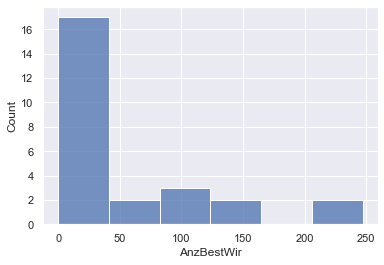

In [20]:
import seaborn as sns
sns.set(style="darkgrid")
sns.histplot(data=mySelection, x="AnzBestWir") #, y="KonOGDKurz")
plt.show();

Test: Choroplethenkarte

**Test: Choroplethenkarte**
Importiere die Geodaten als GeoJSON

In [21]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Filepath statzonen
input_statzonen = r"//szh.loc/ssz/data/GIS/Daten/Vektor/_aktuell/stzh.adm_statzonen_map.json"
df_statzonen = gpd.read_file(input_statzonen)
df_statzonen.head(2)


,objectid,objid,stznr,stzname,qnr,qname,knr,kname,geometry
0,1,154,7303,Hegibach,73,Hirslanden,7,Kreis 7,"POLYGON ((8.55670 47.36407, 8.55670 47.36406, ..."
1,2,89,7302,Klus,73,Hirslanden,7,Kreis 7,"POLYGON ((8.57281 47.35806, 8.57274 47.35804, ..."


Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

#Link https://automating-gis-processes.github.io/site/notebooks/L5/interactive-map-folium.html

# Create a Map instance
m = folium.Map(location=[60.25, 24.8], tiles = 'cartodbpositron', zoom_start=10, control_scale=True)

# Plot a choropleth map
# Notice: 'geoid' column that we created earlier needs to be assigned always as the first column
folium.Choropleth(
    geo_data=data,
    name='Population in 2018',
    data=data,
    columns=['geoid', 'pop18'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    line_color='white',
    line_weight=0,
    highlight=False,
    smooth_factor=1.0,
    #threshold_scale=[100, 250, 500, 1000, 2000],
    legend_name= 'Population in Helsinki').add_to(m)

#Show map
m

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html